In [ ]:
!pip install -r requirements.txt

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import copy
import seaborn as sns
import logging
import time
import random

import llm_utils
import opt_utils

In [5]:
import argparse
parser = argparse.ArgumentParser()
# the following demo is sutiable for gpt2 (all sizes)
# other models (such as meta-llama/Llama-2-7b-chat-hf) may require different settings (such as tokenization and plots configurations)
parser.add_argument('--model_name', type=str, default='gpt2', help='model name (only models that are supported by llm_utils)')
parser.add_argument('--model_args', type=str, default='')
parser.add_argument('--top_k', type=int, default=5, help='top k tokens to extract using logit lens. more tokens will be slower')
parser.add_argument('--disable_pad_token', action='store_true')
parser.add_argument('--norm_ll', action='store_true', help='if to use normalize logit lens')
parser.add_argument('--device', type=str, default=torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))

_StoreAction(option_strings=['--device'], dest='device', nargs=None, const=None, default=device(type='cpu'), type=<class 'str'>, choices=None, required=False, help=None, metavar=None)

In [ ]:
args, unknown = parser.parse_known_args()
print('unknown args:', unknown)
print('args:', args)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(args.model_name)
if not args.disable_pad_token:
    print(f'adding pad token: {tokenizer.eos_token}')
    tokenizer.pad_token = tokenizer.eos_token

try:
    os.environ["TOKENIZERS_PARALLELISM"] = "true"  # not blocking, just to prevent warnings and faster tokenization
except:
    pass

In [8]:
device = torch.device(args.device)
print(f'Using device: {device} [cuda available? => {torch.cuda.is_available()}, cuda version: {torch.version.cuda}, args.device = "{args.device}"]')

Using device: cpu [cuda available? => False, cuda version: 12.1, args.device = "cpu"]


In [ ]:
model_extra_args = {}
for arg in args.model_args.split(','):
    if arg == '':
        continue
    k, v = arg.split('=')
    model_extra_args[k] = v
print(f'model_extra_args: {model_extra_args}')

model = AutoModelForCausalLM.from_pretrained(args.model_name, **model_extra_args).eval().requires_grad_(False).to(device)
model_aux = llm_utils.model_extra(model=model, device=device)
config = model_aux.config  # should be the same as auto_model_to_config(args.model_name)
del model # deleting the model to save memory

n_embd = model_aux.n_embd
n_head = model_aux.n_head
head_size = model_aux.head_size
n_layer = model_aux.n_layer

params_names_filter = opt_utils.only_mlp_filter  # mainly to save memory

In [10]:
subject = 'Obama'
prompt_tmp = '{} grew up in'  # not mandatory to have the prompt in a format that includes "{}" but it is the format used in CounterFact dataset
target_true = ' Hawaii'  # not really used (see final_anwer_ids below)
target_new = ' Paris'


prefix_prompt, postfix_prompt = prompt_tmp.split('{}')
prompt = prompt_tmp.format(subject)
prompt_encoded = tokenizer(prompt, return_tensors="pt").to(device)

if target_new[0] != ' ':
    target_new = ' ' + target_new

prompt_len = prompt_encoded['input_ids'].shape[1]
prompt_list = [tokenizer.decode(x) for x in prompt_encoded['input_ids'][0]]

if prefix_prompt == '':
    start_index_of_subject = 0
    subject_len = tokenizer.encode(subject, return_tensors='pt').shape[1]
else:
    start_index_of_subject = tokenizer.encode(prefix_prompt.rstrip(' '), return_tensors='pt').shape[1]
    subject_len = tokenizer.encode(' ' + subject, return_tensors='pt').shape[1]

print(f'prompt "{prompt}", change: "{target_true}" --> "{target_new}", prompt_len {prompt_len}')


res = opt_utils.get_nll_opt_model(prompt, target_new, model_name=args.model_name,
        tokenizer=tokenizer, opt='SGD', device=device, lr=1.0,
        params_names_filter=params_names_filter,
        wrapp_forward_pass_config='AUTO',
        wrapp_backward_pass_config='AUTO')

model_sgd = res['model']  # updated model
hs_collector = res['hs_collector']  # hidden states
grad_collector = res['grad_collector']  # VJPs
# model_diff = opt_utils.get_models_diff(model_base=model, model_delta=model_sgd, execution_on_cpu=False) # model_adam_diff = model_sgd - model (explaination: model + model_sgd = model_adam)


# what did the model actually predict (before any optimization)
model_final_output = hs_collector[n_layer-1][config.layer_format]['output'][-1]
answer = model_aux.hs_to_token_top_k(model_final_output, k=1)['top_k'][0]
final_anwer_ids = tokenizer.encode(answer, return_tensors='pt')[0][-1:].item()
print(f'\nmodel answer: "{answer}" (id {final_anwer_ids})')

target_new_ids = tokenizer.encode(target_new, return_tensors='pt')[0][-1:].item()  # the "-1:" is used if the output is more than one token long. in particular, in Llama there is a special token for " " (space)
print(f'\ntarget_new: "{target_new}" (id {target_new_ids})')
target_new_tmp = tokenizer.decode(target_new_ids)

prompt "Obama grew up in", change: " Hawaii" --> " Paris", prompt_len 4
Loading config from /content/flow_graph_configs/config_gpt2.json
{'config_name': 'gpt2', 'layer_format': 'transformer.h.{}', 'layer_mlp_format': 'transformer.h.{}.mlp', 'layer_attn_format': 'transformer.h.{}.attn', 'ln1': 'transformer.h.{}.ln_1', 'attn_q': 'transformer.h.{}.attn.c_attn', 'attn_k': 'transformer.h.{}.attn.c_attn', 'attn_v': 'transformer.h.{}.attn.c_attn', 'attn_o': 'transformer.h.{}.attn.c_proj', 'ln2': 'transformer.h.{}.ln_2', 'mlp_ff1': 'transformer.h.{}.mlp.c_fc', 'mlp_ff2': 'transformer.h.{}.mlp.c_proj', 'mlp_act': 'transformer.h.{}.mlp.act', 'include_mlp_bias': True, 'include_attn_bias': True}
Loading config from /content/flow_graph_configs/config_gpt2.json
{'config_name': 'gpt2', 'layer_format': 'transformer.h.{}', 'layer_mlp_format': 'transformer.h.{}.mlp', 'layer_attn_format': 'transformer.h.{}.attn', 'ln1': 'transformer.h.{}.ln_1', 'attn_q': 'transformer.h.{}.attn.c_attn', 'attn_k': 'transfo

In [11]:
extractor = {}  # holds the logit lens (ll) results extracted from hidden states and VJPs

for layer_index in range(n_layer):
    extractor[layer_index] = {}
    for collector, collector_name in [(hs_collector, "hidden_states"), (grad_collector, "grad_states")]:
        extractor[layer_index][collector_name] = {}
        # for layer_type in collector[layer_index]:  # NOTE: this line was edited to the next line to make the run faster
        for layer_type in [config.layer_format, config.mlp_ff1, config.mlp_ff2]:
            extractor[layer_index][collector_name][layer_type] = {}
            for input_output in ['input', 'output']:
                if len(collector[layer_index][layer_type][input_output]):
                    extractor[layer_index][collector_name][layer_type][input_output] = {'logit_lens_top': [], 'logit_lens_bottom': [],
                                                                                            'norms': [], 'rank_original_anwer': [], 'rank_target_new': []}
                    if args.norm_ll:  # if we wantd to compute the normalized logit lens
                        extractor[layer_index][collector_name][layer_type][input_output]['normed_logit_lens_top'] = []
                        extractor[layer_index][collector_name][layer_type][input_output]['normed_logit_lens_bottom'] = []
                        extractor[layer_index][collector_name][layer_type][input_output]['normed_rank_original_anwer'] = []
                        extractor[layer_index][collector_name][layer_type][input_output]['normed_rank_target_new'] = []

                    for row in collector[layer_index][layer_type][input_output]:
                        curr_norm = row.norm()
                        extractor[layer_index][collector_name][layer_type][input_output]['norms'].append(round(curr_norm.item(), 4))

                        if row.shape[0] == n_embd:
                            curr_ll_res = model_aux.hs_to_token_top_k(row, k=args.top_k, return_probs=True)
                            curr_probs = curr_ll_res['probs']
                            curr_top_k = curr_ll_res['top_k']
                            curr_bottom_k = curr_ll_res['bottom_k']
                            extractor[layer_index][collector_name][layer_type][input_output]['logit_lens_top'].append(curr_top_k)
                            extractor[layer_index][collector_name][layer_type][input_output]['logit_lens_bottom'].append(curr_bottom_k)

                            rank_anwer = model_aux.get_token_rank_from_probs(token=final_anwer_ids, probs=curr_probs)
                            rank_target_new = model_aux.get_token_rank_from_probs(token=target_new_ids, probs=curr_probs)
                            extractor[layer_index][collector_name][layer_type][input_output]['rank_original_anwer'].append(rank_anwer)
                            extractor[layer_index][collector_name][layer_type][input_output]['rank_target_new'].append(rank_target_new)

                            if args.norm_ll:
                                row_normed = torch.nn.functional.normalize(row, dim=0)
                                curr_ll_res = model_aux.hs_to_token_top_k(row_normed, k=args.top_k, return_probs=True)
                                curr_probs = curr_ll_res['probs']
                                curr_top_k = curr_ll_res['top_k']
                                curr_bottom_k = curr_ll_res['bottom_k']
                                extractor[layer_index][collector_name][layer_type][input_output]['normed_logit_lens_top'].append(curr_top_k)
                                extractor[layer_index][collector_name][layer_type][input_output]['normed_logit_lens_bottom'].append(curr_bottom_k)

                                rank_anwer = model_aux.get_token_rank_from_probs(token=final_anwer_ids, probs=curr_probs)
                                rank_target_new = model_aux.get_token_rank_from_probs(token=target_new_ids, probs=curr_probs)
                                extractor[layer_index][collector_name][layer_type][input_output]['normed_rank_original_anwer'].append(rank_anwer)
                                extractor[layer_index][collector_name][layer_type][input_output]['normed_rank_target_new'].append(rank_target_new)

In [12]:
def short_and_fit(x, gap=8, flag_only_bottom=False):
    x_readable = x.replace('$', '?')
    if flag_only_bottom:
        if len(x_readable) > 2*gap:
            return x_readable[:2*gap-1] + '..'
        else:
            return x_readable
    else:
        tmp_index = x_readable.index(' \ ') if ' \ ' in x else len(x_readable)//2
        left = 0
        pad_left = ''
        if tmp_index-gap > 0:
            left = tmp_index-gap
            pad_left = '..'
        right = len(x_readable)
        pad_right = ''
        if tmp_index+gap < len(x_readable):
            right = tmp_index+gap
            pad_right = '..'
        return pad_left + x_readable[left:right] + pad_right

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 40845 (\N{CJK UNIFIED IDEOGRAPH-9F8D}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12468 (\N{KATAKANA LETTER GO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12531 (\N{KATAKANA LETTER N}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


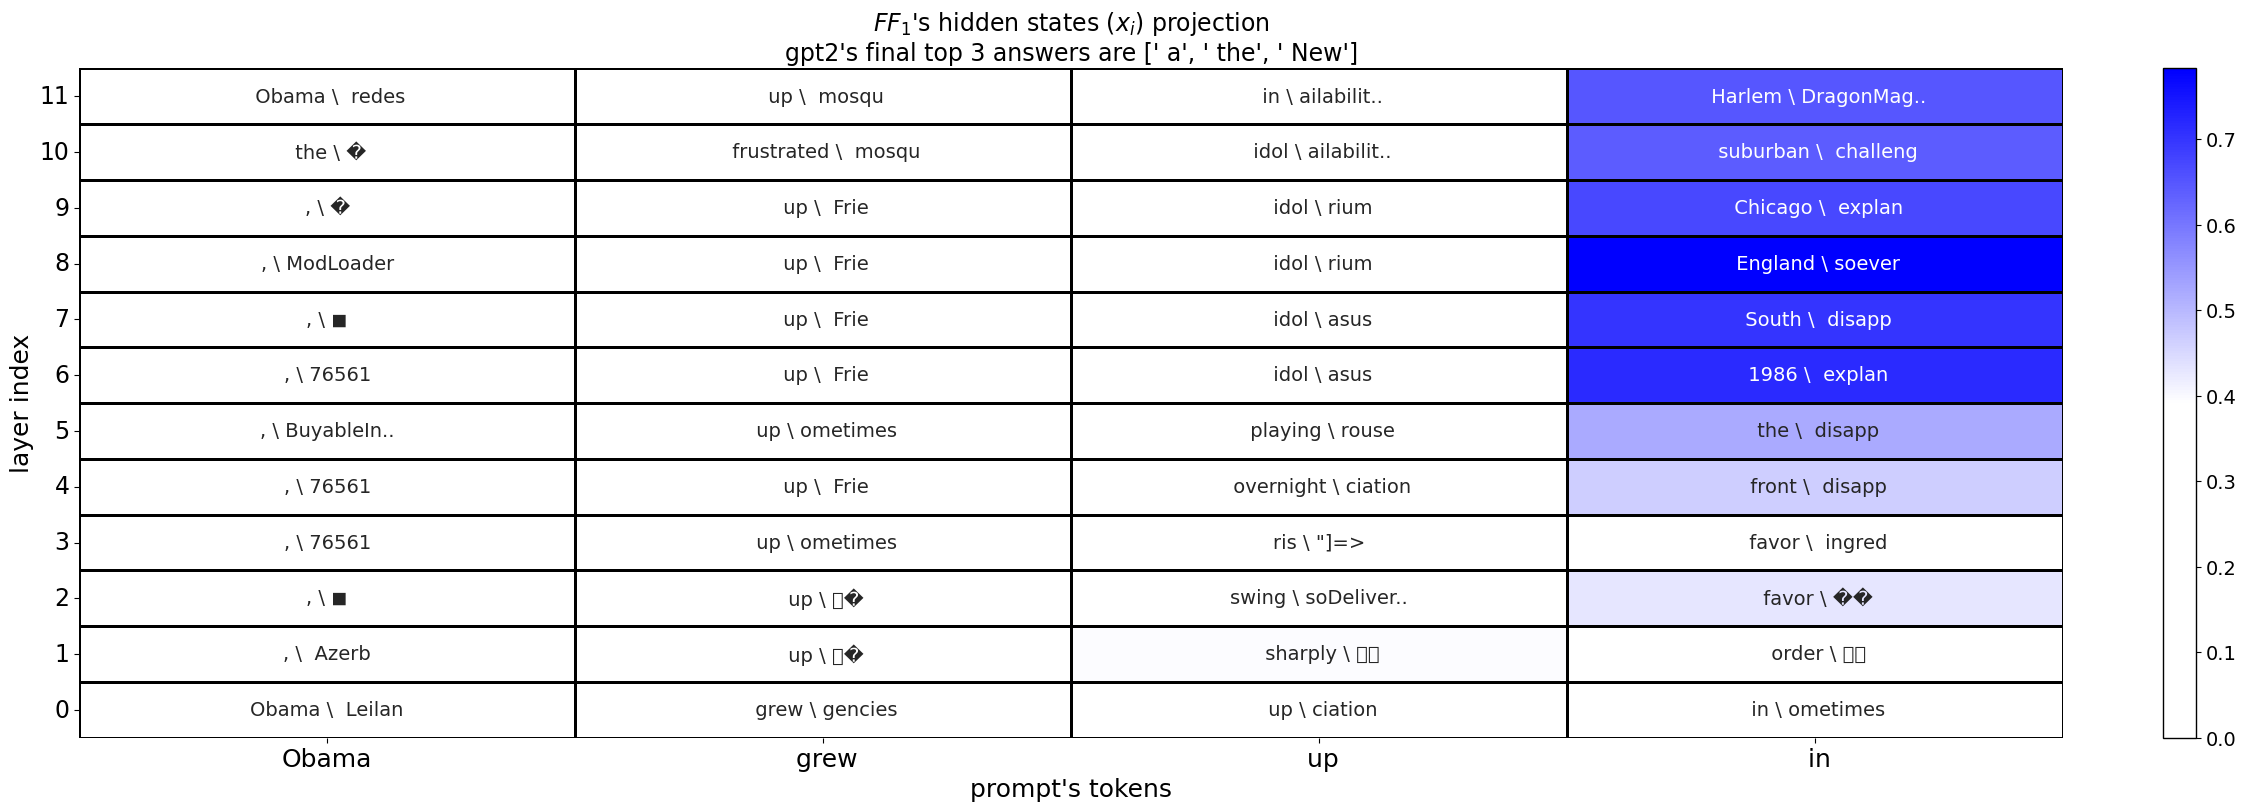

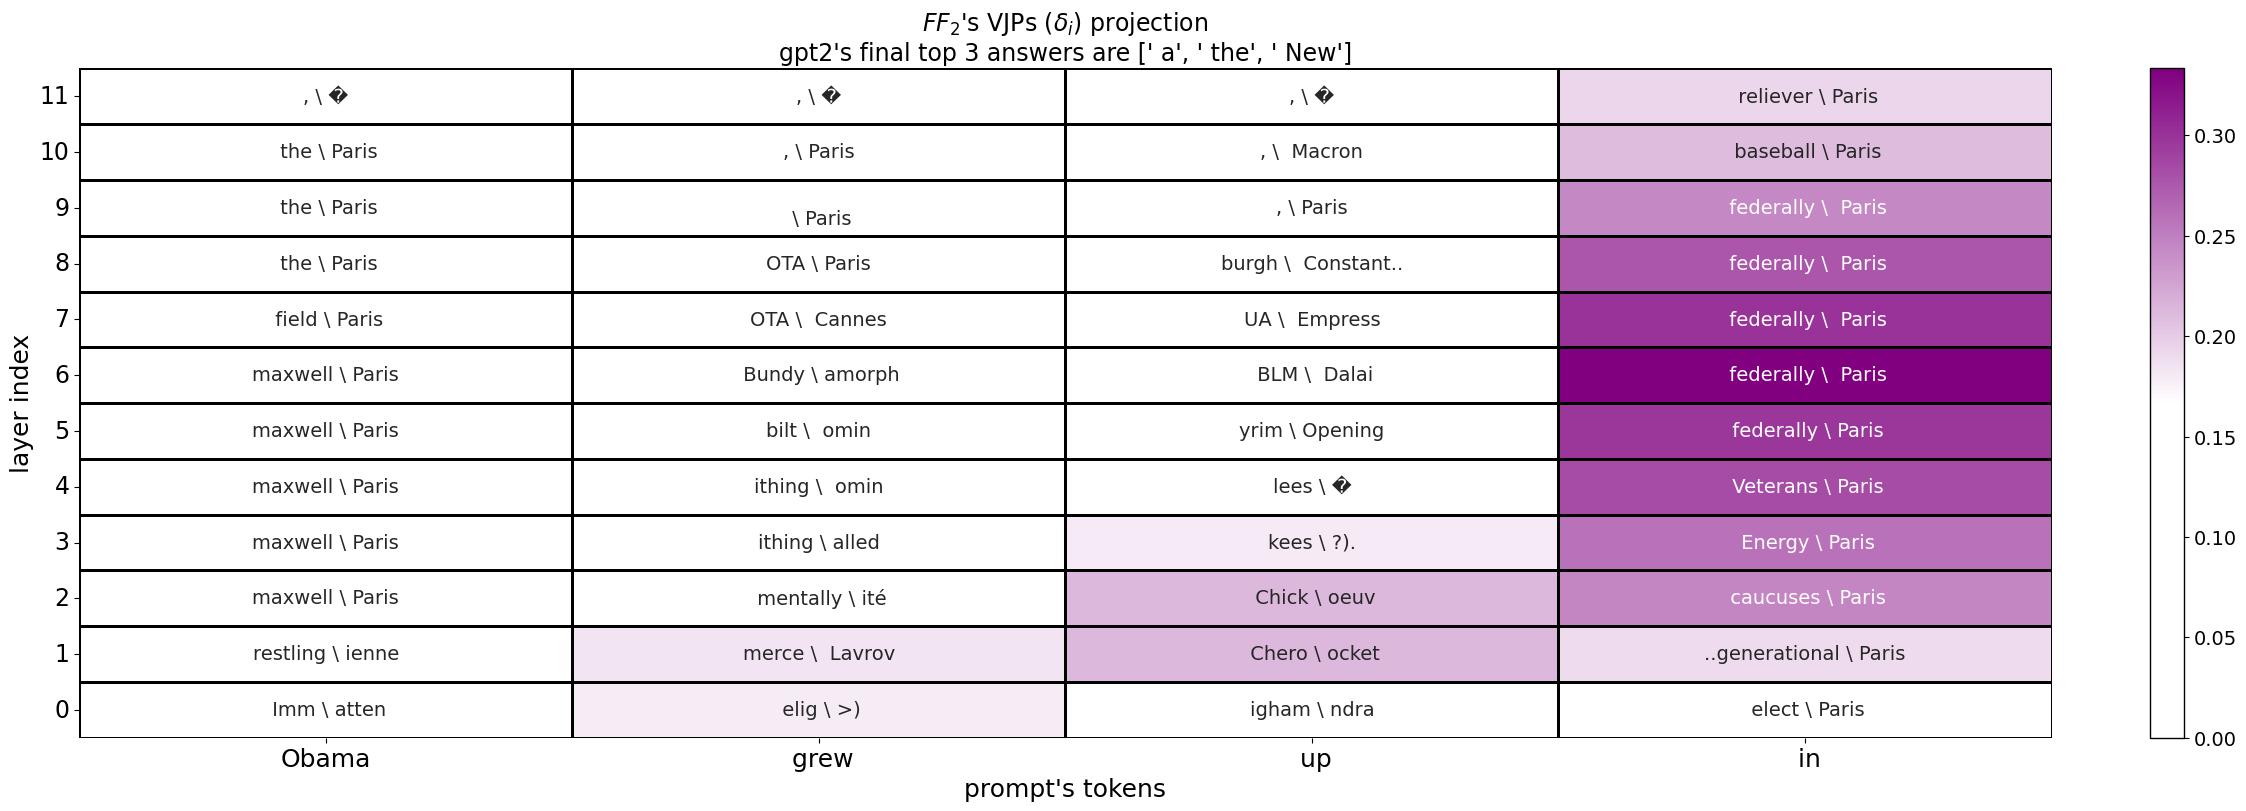

In [13]:
plt.rcParams['font.sans-serif']=['SimHei']  # Show non-English characters
plt.rcParams['axes.unicode_minus']=False    # Without these lines, seaborn might fail to show non-English characters
# might cause some warnings, but they are ignorable. disable the warnings:
logging.getLogger('matplotlib.font_manager').disabled = True

ColorA = mpl.colors.LinearSegmentedColormap.from_list('ColorA', 2*['white'] + ['purple'])
ColorB = mpl.colors.LinearSegmentedColormap.from_list('ColorB', 2*['white'] + ['blue'])

######### plot settings (change depend on the models and prompt) #########
tokens_to_show = 1  # how many tokens to show from the head/tail of the logit lens
show_every_n_layer = 1  # to show all layers, set to 1. to save space, set to higher integer
height_pre_cell = 0.7  # the size of each cell
ratio = 0.7
table_font_size = 14
flag_only_bottom = False  # True will present only the least probable tokens,
# False will show most probable and least probable tokens in the format: "most probable \ least probable"
# (in the paper we talk about how due the negative learning rate, we are interested in the least probable tokens)
gap=12  # what is the maximum number of characters to show in the table (to prevent the overlap of the text)
normed_or_nothing = ""  # if using the normalized logit lens, set to "normed_" otherwise set to ""
# normed_or_nothing = "normed_"
flip_table=False  # the last layer is on top or on the bottom
height = len(extractor)*height_pre_cell//show_every_n_layer
width = height * prompt_len * ratio
##########################################################################


for layer_type, hidden_states_grads, title_tmp in [
    (config.mlp_ff1, 'hidden_states', '$FF_1$\'s hidden states ($x_i$) projection'),
    (config.mlp_ff2, 'grad_states', '$FF_2$\'s VJPs ($\delta_i$) projection')
    ]:
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(width, height), constrained_layout=True)
    data_tokens = []
    data_colors = []

    # each mlp matrix has only one dimension that logit lens can be computed on
    # for FF1, this is the input dimension, and we project its hidden states
    # for FF2, this is the output dimension, and we project its VJPs
    # remember, the gradient are the outer product of the hidden states and the VJPs, so in both cases we project the embeddings that are in each of the matrices
    input_output = 'output' if len(extractor[1][hidden_states_grads][layer_type]['output']['logit_lens_top']) else 'input'

    # first, extract the logit lens info into a table
    for tmp_index, layer_index in enumerate(extractor):
        if tmp_index % show_every_n_layer == 0:
            try:
                curr_hs_top = extractor[layer_index][hidden_states_grads][layer_type][input_output][f'{normed_or_nothing}logit_lens_top']
                curr_hs_bottm = extractor[layer_index][hidden_states_grads][layer_type][input_output][f'{normed_or_nothing}logit_lens_bottom']
                # curr_norms = extractor[layer_index][hidden_states_grads][layer_type][input_output]['norms']
                curr_norms = extractor[layer_index]['grad_states'][layer_type]['output']['norms']
            except:
                curr_hs_top = [[""] for _ in range(prompt_len)]
                curr_hs_bottm = [[""] for _ in range(prompt_len)]
                curr_norms = [0 for _ in range(prompt_len)]

            if flag_only_bottom:
                curr_row_rokens = [" ".join(x[:tokens_to_show]) for x in curr_hs_bottm]
            else:
                curr_row_rokens = [" ".join(x[:tokens_to_show]) + " \ " + " ".join(y[:tokens_to_show]) for x, y in zip(curr_hs_top, curr_hs_bottm)]

            curr_row_rokens = [short_and_fit(x, gap=gap, flag_only_bottom=flag_only_bottom) for x in curr_row_rokens]
            data_tokens.append(curr_row_rokens)
            data_colors.append(curr_norms)

    # second, plot the table (setting all properties of the table)
    curr_color = ColorB if hidden_states_grads == 'hidden_states' else ColorA
    if not flip_table:
        data_color_tmp = []
        data_tokens_tmp = []
        for row in data_colors:
            data_color_tmp.insert(0, row)
        for row in data_tokens:
            data_tokens_tmp.insert(0, row)
        data_colors = data_color_tmp
        data_tokens = data_tokens_tmp

    sns.heatmap(data_colors, cmap=curr_color, vmin=0, annot=data_tokens, fmt='', linewidths=0.9, linecolor='black', ax=axes, annot_kws={'size': table_font_size})
    axes.set_xticks(np.arange(prompt_len)+0.5, prompt_list, rotation=0, fontsize=18)
    actuall_y_axis = [x for x in range(0, len(extractor), show_every_n_layer)]
    if not flip_table:
        actuall_y_axis = actuall_y_axis[::-1]
    # axes.set_yticks(actuall_y_axis)
    axes.set_yticklabels(actuall_y_axis, rotation=0, fontsize=17)
    axes.set_ylabel('layer index', fontsize=18)
    axes.set_xlabel('prompt\'s tokens', fontsize=18)
    # make the colovbar text bigger and warp the cplorbar with black lines
    cbar = axes.collections[0].colorbar
    cbar.ax.tick_params(labelsize=14)
    cbar = axes.collections[0].colorbar
    cbar.outline.set_edgecolor('black')
    cbar.outline.set_linewidth(1)
    cbar.dividers.set_color('black')
    cbar.dividers.set_linewidth(1)
    cbar.dividers.set_linestyle('solid')

    n_top_answers = 3
    model_name_tmp = args.model_name.split('/')[-1].lstrip('-hf')
    model_final_answer = extractor[layer_index]['hidden_states'][config.layer_format]['output']['logit_lens_top'][-1][:n_top_answers]
    plt.title(f'{title_tmp}\n{model_name_tmp}\'s final top {n_top_answers} answers are {model_final_answer}', fontsize=17)
    plt.show()

print('\n\n')


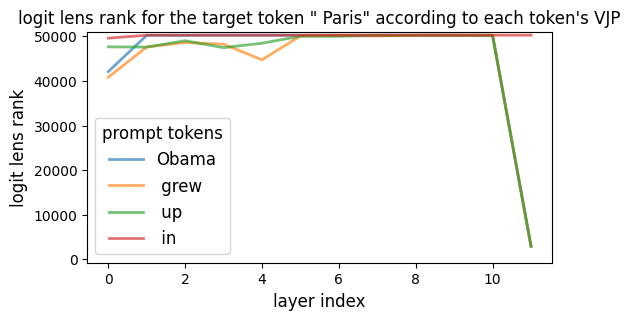

,0,1,2,3,4,5,6,7,8,9,10,11
1~~Obama,42090,50228,50247,50251,50252,50250,50252,50252,50252,50253,50250,2913
2~~ grew,40829,47609,48615,48238,44731,50095,50172,50085,50235,50255,50244,2913
3~~ up,47637,47588,49012,47465,48453,50023,50013,50220,50236,50222,50170,2913
4~~ in,49593,50250,50243,50255,50255,50255,50256,50256,50256,50256,50255,50255


In [14]:
# plot of the target answer per each token in the prompt
# we expect the target answer to be the least probable token in the prompt (rank as the vocab size)
# remember all tokens but the prompt's last do not have a valid VJP at the last layer, hence we will see a drop in the rank of the target token at their last layer

layer_type = config.mlp_ff2
input_output = 'output'
collector_name = 'grad_states'
graph_data = {}
for token_index, token in enumerate(prompt_list):
    tmp_label  = f'{token_index+1}~~{token}'  # in case the prompt has a token that appears more than once
    graph_data[tmp_label] = []
    for layer_index in range(n_layer):
        target_rank = extractor[layer_index][collector_name][layer_type][input_output]['rank_target_new'][token_index]
        graph_data[tmp_label].append(target_rank)

plt.figure(figsize=(6, 3))
sns.lineplot(data=graph_data, dashes=False, linewidth=2, alpha=0.65)
plt.ylim(0 - 777, tokenizer.vocab_size + 777)  # the 777 is just to make the plot look better (or the lines will be on the edge of the plot)
plt.ylabel('logit lens rank', fontsize=12)
plt.xlabel('layer index', fontsize=12)
# edit the labels of the legend
handles, labels = plt.gca().get_legend_handles_labels()
plt.gca().legend(handles, [x.split('~~')[1] for x in labels], title='prompt tokens', title_fontsize=12, fontsize=12, loc='best')
plt.title(f'logit lens rank for the target token "{target_new_tmp}" according to each token\'s VJP')
plt.show()

df = pd.DataFrame(graph_data).T
df

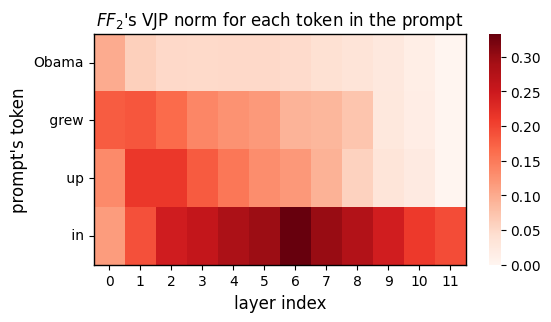

,0,1,2,3,4,5,6,7,8,9,10,11
1~~Obama,0.0992,0.0600,0.0499,0.0492,0.0497,0.0498,0.0473,0.0405,0.0340,0.0248,0.0147,0.0000
2~~ grew,0.1788,0.1843,0.1659,0.1378,0.1257,0.1178,0.0922,0.0880,0.0724,0.0271,0.0159,0.0000
3~~ up,0.1332,0.2126,0.2134,0.1803,0.1530,0.1311,0.1189,0.0933,0.0581,0.0317,0.0221,0.0000
4~~ in,0.1152,0.1888,0.2457,0.2588,0.2834,0.2969,0.3333,0.3002,0.2762,0.2441,0.2107,0.1932


In [15]:
# plot of the norm of the VJPs as a heatmap
layer_type = config.mlp_ff2
input_output = 'output'
collector_name = 'grad_states'
graph_data = {}
for token_index, token in enumerate(prompt_list):
    tmp_label  = f'{token_index+1}~~{token}'  # in case the prompt has a token that appears more than once
    graph_data[tmp_label] = []
    for layer_index in range(n_layer):
        target_rank = extractor[layer_index][collector_name][layer_type][input_output]['norms'][token_index]
        graph_data[tmp_label].append(target_rank)

df2 = pd.DataFrame(graph_data).T
df2

plt.figure(figsize=(6, 3))
sns.heatmap(data=df2, vmin=0, annot=False, cmap='Reds')
plt.ylabel('prompt\'s token', fontsize=12)
plt.yticks([x+0.5 for x in range(len(prompt_list))], prompt_list, rotation=0, fontsize=10)
plt.xlabel('layer index', fontsize=12)
ax = plt.gca()
for _, spine in ax.spines.items():
    spine.set_visible(True)
    spine.set_linewidth(1)
plt.title(f'$FF_2$\'s VJP norm for each token in the prompt')
plt.show()

df2

In [16]:
llm_utils.describe_dict(extractor)

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
dict_keys(['hidden_states', 'grad_states'])
dict_keys(['transformer.h.{}', 'transformer.h.{}.mlp.c_fc', 'transformer.h.{}.mlp.c_proj'])
dict_keys(['input', 'output'])
dict_keys(['logit_lens_top', 'logit_lens_bottom', 'norms', 'rank_original_anwer', 'rank_target_new'])


In [17]:
# # save the run results in a json file (include extractor, prompt, subject, target_new, model_answer)
# import json
# data = {
#     'prompt': prompt,
#     'subject_len': subject_len,
#     'prompt_len': prompt_len,
#     'target_new': target_new,
#     'target_new_tmp': target_new_tmp,
#     'model_answer': answer,
#     'extractor': extractor
# }

# out_path = f'<TODO path_out>.json'
# with open(out_path, 'w') as f:
#     json.dump(data, f, indent=4)